# Base LSH and Multi Probe LSH example
Download color histograms of the flick30k dataset [here](https://www.kaggle.com/ritchie46/flickr30khistograms/download).

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from floky import L2 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time

## Data preparation
First we load the data in numpy. Next we compute the real $N$ nearest neighbors with `scipy.spatial.distance.cdist`. 

From these $N$ distance results we compute the mean and determine the top k results. 
Next we scale the data by $R$. This makes it easier to verify if the LSH algorithm can find nearest neighbors.
If we scale the data by $\frac{1}{R}$ we expect the exact Nearest Neighbor to have a distance smaller than 1. If this isn't the case, we need to choose another distance $R$.


In [2]:
with open("flickr30k_histograms.csv") as f:
    a = np.loadtxt(f, delimiter=",")

In [3]:
# We will do N queries and compute recall and query times.
N = 100

In [23]:
# Find the exact nearest neighbors. This is needed to compute recall.
t0 = time.time_ns()
dist = cdist(a[:N], a)
# ms
exact_duration = (time.time_ns() - t0) / 1e6
exact_duration 

1808.042179

In [5]:
# non trivial top 1
# we skip the first as that is the query point itself
top_k = dist.argsort(1)[:, 1:2]
mean = dist.mean()
top_k_dist = dist[np.arange(N)[:, None], top_k]

In [6]:
# Scale data by distance. So scaled R will be 1.
R = mean / 2.5
a /= R
dist /= R
top_k_dist /= R
R

12717.77025887411

In [7]:
# Check if real nearest neigbors are < R = 1
print("{}% < R".format((top_k_dist < 1).sum() / (top_k_dist.shape[0] * top_k_dist.shape[1]) * 100))
top_k_dist[:10]

83.0% < R


array([[0.99372539],
       [0.45435497],
       [0.79676334],
       [1.14787659],
       [0.78890876],
       [0.63275089],
       [0.58949666],
       [0.99201873],
       [1.52371323],
       [1.61113221]])

## Comparison Query / Preprocessing duration and Recall
Below we'll examine the impact of the query duration on the recall.

We take a look at two **k** (# of values in the hash) values:
    * 15
    * 30
    
For Base LSH we increase the numebr of hash tables to increase the recall.<br>
For Multi-probe LSH we increase the number of probes we execute. We will keep the number of hash tables constant to only **5**.

In [8]:
def cum_mov_avg(x, avg, n):
    return (x + n * avg) / (n + 1)

def recall(k, L):
    dim = len(a[0])
    lsh = L2(k, L, dim, in_mem=True)
    
    t0 = time.time()
    lsh.fit(a)
    fit_duration = time.time() - t0
    
    t0 = time.time_ns()
    p = lsh.predict(a[:N], only_index=True, top_k=6);
    predict_duration = time.time_ns() - t0
    
    c = 0
    avg_collisions = 0
    for i, pi in enumerate(p):
        if pi.n_collisions == 1:
            continue
        idx = set(pi.index[1:])
        if len(idx.intersection(top_k[i])) > 0:
            c += 1
        avg_collisions = cum_mov_avg(pi.n_collisions, avg_collisions, i)

    return c / N, avg_collisions, fit_duration, predict_duration

ks = []
Ls = []
recalls = []
avg_cs = []
duration_fit = []
duration_predict = []
for k in [15, 30]:
    for L in [5, 10, 15, 20, 50, 100]:
        ks.append(k)
        Ls.append(L)
        
        r, avg_collision, fit_duration, predict_duration = recall(k, L)
        duration_fit.append(fit_duration)
        duration_predict.append(predict_duration)
        recalls.append(r)
        avg_cs.append(avg_collision)

32000it [00:00, 60119.95it/s]                           
32000it [00:01, 30086.65it/s]                           
32000it [00:01, 21003.48it/s]                           
32000it [00:01, 16029.99it/s]                           
32000it [00:04, 6494.46it/s]                           
32000it [00:10, 2953.71it/s]                           
32000it [00:01, 17412.80it/s]                           
32000it [00:03, 9178.54it/s]                            
32000it [00:05, 6099.98it/s]                           
32000it [00:06, 5050.17it/s]                           
32000it [00:15, 2131.61it/s]                           
32000it [00:31, 1020.02it/s]                           


In [9]:
df = pd.DataFrame({"recall": recalls,
             "avg_collisions": avg_cs,
             "L": Ls,
             "K": ks,
             "duration_fit": duration_fit,
             "duration_predict": duration_predict
             })
df

,recall,avg_collisions,L,K,duration_fit,duration_predict
0,0.37,715.617084,5,15,0.559304,58695551
1,0.58,1187.012150,10,15,1.106947,79070180
2,0.76,2370.829281,15,15,1.546288,148368772
3,0.74,1914.947429,20,15,2.016144,135169832
4,0.91,4319.069349,50,15,4.948727,256704612
5,0.95,6013.273606,100,15,10.858258,407418596
6,0.14,30.292026,5,30,1.858710,12629968
7,0.26,188.690972,10,30,3.517005,31498599
8,0.30,77.511316,15,30,5.282044,21663692
9,0.37,176.957555,20,30,6.364206,26374739


In [10]:
def recall_multi_probe(k, budget, lsh):
    lsh.multi_probe(budget)
    t0 = time.time_ns()
    p = lsh.predict(a[:N], only_index=True, top_k=6);
    predict_duration = time.time_ns() - t0
    
    c = 0
    avg_collisions = 0
    for i, pi in enumerate(p):
        if pi.n_collisions == 1:
            continue
        idx = set(pi.index[1:])
        if len(idx.intersection(top_k[i])) > 0:
            c += 1
        avg_collisions = cum_mov_avg(pi.n_collisions, avg_collisions, i)

    return c / N, avg_collisions, predict_duration

ks = []
recalls = []
avg_cs = []
probes = []
duration_fit = []
duration_predict = []
for k in [15, 30]:
    dim = len(a[0])
    
    t0 = time.time()
    lsh = L2(k, 5, dim, in_mem=True)
    fit_duration = time.time() - t0
    lsh.fit(a)
    
    for probe in [10, 20, 15, 20, 50, 100]:
        ks.append(k)
        probes.append(probe)
        
        r, avg_collision, predict_duration = recall_multi_probe(k, probe, lsh)
        duration_predict.append(predict_duration)
        duration_fit.append(fit_duration)
        recalls.append(r)
        avg_cs.append(avg_collision)

32000it [00:00, 37000.65it/s]                          
32000it [00:01, 19196.08it/s]                           


In [11]:
df_mp = pd.DataFrame({"recall": recalls,
             "avg_collisions": avg_cs,
              "probes": probes,
             "K": ks,
                                   "duration_fit": duration_fit,
             "duration_predict": duration_predict
             })
df_mp

,recall,avg_collisions,probes,K,duration_fit,duration_predict
0,0.84,3568.653046,10,15,0.000322,218376250
1,0.88,4608.842829,20,15,0.000322,295503006
2,0.85,4171.139471,15,15,0.000322,261069746
3,0.88,4608.842829,20,15,0.000322,297343177
4,0.91,6259.458000,50,15,0.000322,720279473
5,0.93,7812.191200,100,15,0.000322,1141625211
6,0.36,263.895373,10,30,0.006047,27857108
7,0.46,359.867660,20,30,0.006047,31135252
8,0.43,311.102990,15,30,0.006047,28399008
9,0.46,359.867660,20,30,0.006047,32754926


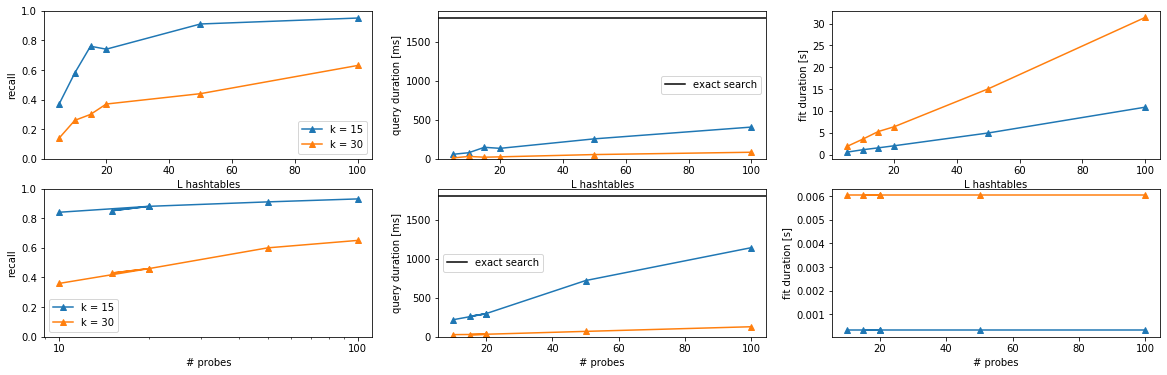

In [38]:
fig, ax = plt.subplots(figsize=(20, 6), nrows=2, ncols=3)

for i, (k, df_) in enumerate(df.groupby("K")):
    color = f"C{i}"
    marker = "^"
    ax[0, 0].plot(df_.L, df_.recall, c=color, marker=marker, label=f"k = {k}")
    ax[0, 1].plot(df_.L, df_.duration_predict / 1e6, c=color, marker=marker)
    ax[0, 2].plot(df_.L, df_.duration_fit, c=color, marker=marker)
    
for i, (k, df_) in enumerate(df_mp.groupby("K")):
    color = f"C{i}"
    ax[1, 0].plot(df_.probes, df_.recall, c=color, marker=marker, label=f"k = {k}")
    ax[1, 1].plot(df_.probes, df_.duration_predict / 1e6, c=color, marker=marker)
    ax[1, 2].plot(df_.probes, df_.duration_fit, c=color, marker=marker)
        
ax[0, 0].legend()
ax[1, 0].legend()

ax[0, 1].axhline(exact_duration, c="black", label="exact search")
ax[1, 1].axhline(exact_duration, c="black", label="exact search")
ax[0, 1].legend()
ax[1, 1].legend()


plt.xlabel("L")
ax[0, 0].set_ylabel("recall")
ax[0, 0].set_ylim(0, 1)
ax[0, 0].set_xlabel("L hashtables")
ax[0, 1].set_xlabel("L hashtables")
ax[0, 1].set_ylabel("query duration [ms]")
ax[0, 1].set_ylim(0, exact_duration * 1.05)
ax[0, 2].set_ylabel("fit duration [s]")
ax[0, 2].set_xlabel("L hashtables")

ax[1, 0].set_ylabel("recall")
ax[1, 0].set_xlabel("# probes")
ax[1, 0].set_ylim(0, 1)
ax[1, 0].set_xscale("log")
ax[1, 0].xaxis.set_major_formatter(ScalarFormatter())
ax[1, 1].set_xlabel("# probes")
ax[1, 1].set_ylabel("query duration [ms]")
ax[1, 1].xaxis.set_major_formatter(ScalarFormatter())
ax[1, 1].yaxis.set_major_formatter(ScalarFormatter())
ax[1, 1].set_ylim(0, exact_duration * 1.05)

ax[1, 2].set_ylabel("fit duration [s]")
ax[1, 2].set_xlabel("# probes")

plt.show() 